In [50]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]
villes = sorted(villes, key=len)

In [4]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [5]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # account for <SOS> and <EOS>, which are appened at the beg. and end of each seq

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [6]:
def get_batch(split, batch_size):
    # returns a batch, according to the data pipeline written in the W&B report
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(high=data.shape[0], size=(1,), dtype=torch.int32).item() #sample la ligne seed autour de laquelle on va piocher les exemples

    if split == 'train':
        idx = torch.randint(low = max(0, idx_seed - 4 * batch_size), high = min(data.shape[0], idx_seed + 4 * batch_size), size=(batch_size,), dtype=torch.int32) #samples les indices du batch à produire
        
    else:
        start = max(0, idx_seed-batch_size/2)
        end =  min(data.shape[0]-1, idx_seed+batch_size/2)

        if end-start != batch_size:
            if start == 0:
                end = end - (idx_seed-batch_size/2 - start)
            else:
                start = start - (idx_seed+batch_size/2 - end)

        start, end = int(start), int(end)

        idx = torch.arange(start=start, end=end, dtype=torch.int64)
        
    #pq 4 ? bon compromis entre assez large pour pas bcp de répétitions, assez petit pour pas bcp de padding (cf data.ipynb)
    #en moyenne sur un batch, 6.7 d'écart en max_len et min_len (donc en moyenne pour une séq., 3,3 de padding) (ça fait bcp finalement? a comparer devant la longueur d'un mot) et max_len 17.8
    #longueur moyenne d'une séq. : 11.6. donc en moyenne pour une séq., on rajoute 28% de compute inutile...
    #on aura forcement pas mal de padding sur le val car dataset comparable devant 4*batch_size

    #pour 2, on aura 3.5 d'écart, donc 1.7 de padding
    # donc 14% de compute inutile par mot

    #pour 2, on a 12% des exemples qui sont des répétitions (122 pour un batch de 1024, en moyenne)
    #pour 4, seulement 6% (67 exemples)

    #pour batch_size=512
    #pour 2, 5% de répétitions, 1.8 de disp. donc 0.9 de padding (soit 7% de compute inutile par séq.)
    #pour 4, 3% de répétitions, 3.5 de disp. donc 1.7 de padding (soit 14% de compute inutile par séq.)

    #pour privilégier des données iid, je choisi de partir sur 4 (pour avoir des batch diversifiés, au détriment d'un peu de compute inutile)
    #voir considérer plus ?
    
    #pour le val. set, 4 semble bcp trop
    #pour 4, 12% de répétitions, 15 de disp. donc 7 de padding (soit plus de 50% de compute lost)
    #c'est dommage, vu qu'avoir des batchs diversifiés n'a aucun interet pour le calcul du loss, donc on ne fait que perdre du compute
    #mais le pb avec 1 (par exemple) c'est qu'on a enormément de répétitions (25%) au sein d'un batch... donc estimation du cout totalement erronée
    #je choisis d'adopter une stratégie un peu différente: sample idx_seed, et on prends tous les index entre idx_seed-batch_size/2 et idx_seed+batch_size/2

    idx_sorted, _ = torch.sort(idx) #on les ordonne pour recuperer facilement la longueur de la plus grande seq. du batch

    X_batch = data[idx_sorted] #on extrait la matrice qui va produire Xb et Yb

    max_len_batch = torch.sum(torch.ne(X_batch[-1], char_to_int['<pad>'])) #longueur de la plus grande seq. du batch : torch.ne(X_batch[-1], 0) crée une matrice masque, avec True si diff de 0, False si egal a 0

    Xb = X_batch[:, :max_len_batch-1] #on selectionne que jusqu'a la len max - 1 (<EOS> du plus long inutile) (le reste n'est que padding)
    Yb = X_batch[:, 1:max_len_batch] #meme que Xb, mais décalé de 1 (avec le <EOS> mais sans le <SOS>)

    #Xb[Xb == 1] = -1 #on remplace le <EOS> par du padding (totalement optionnel)

    Xb = Xb.pin_memory().to('cuda', non_blocking=True)
    Yb = Yb.type(torch.LongTensor).pin_memory().to('cuda', non_blocking=True)
    #Yb = Yb.type(torch.LongTensor)

    return Xb, Yb

#todo: mettre les shapes a cote

In [73]:
embed_dim = 32
d_model = 128
n_heads = 1
d_head = d_model // n_heads

d_query = 16
d_key = d_query
d_value = d_head

In [62]:
class NewGELU(nn.Module):
    """
    GELU paper: https://arxiv.org/abs/1606.08415
    """
    
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.X_to_query = nn.Linear(embed_dim, d_query, bias=False)
        self.X_to_key = nn.Linear(embed_dim, d_key, bias=False)
        self.X_to_value = nn.Linear(embed_dim, d_value, bias=False)

    def forward(self, X):
        # X : (B, T, embed_dim), tagrets: (B, T)

        B, T, _ = X.size()

        Q = self.X_to_query(X) # (B, T, d_query)
        K = self.X_to_key(X) # (B, T, d_key=d_query)
        V = self.X_to_value(X) # (B, T, d_value)

        QK_T = Q @ torch.transpose(K, 1, 2) # (B, T, T)

        mask = torch.tril(torch.ones((T, T), dtype=torch.int32)).bool()
        QK_T[:, ~mask] = -float("inf")

        attention_scores = torch.softmax(QK_T / math.sqrt(d_key), dim=2) # (B, T, T)
        attention = attention_scores @ V # (B, T, d_value=d_head)

        return attention

class Transformer_LM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(len(vocabulaire), embed_dim, padding_idx=0)
        self.sa = SelfAttention()
        self.fc1 = nn.Linear(d_model, 4*d_model)
        self.act = NewGELU()
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.lm_head = nn.Linear(d_model, len(vocabulaire))

    def forward(self, W, targets):
        # W : (B, T), tagrets: (B, T)

        X = self.embed(W) # (B, T, embed_dim)
        H = self.sa(X)
        H = self.act(self.fc1(H))
        H = self.fc2(H)
        logits = self.lm_head(H) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0)

        return logits, loss





In [63]:
Xb, Yb = get_batch('train', 512)

In [64]:
model = Transformer_LM().to(device)

In [65]:
logits, loss = model(Xb, Yb)

In [74]:
model = Transformer_LM().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.01)

In [76]:
total_params = sum(p.numel() for p in model.parameters())
total_params

144238

In [77]:
lossi = []

In [80]:
for _ in range(1000):
    Xb, Yb = get_batch('train', 1024)

    #forward
    logits, loss = model(Xb, Yb)

    lossi.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

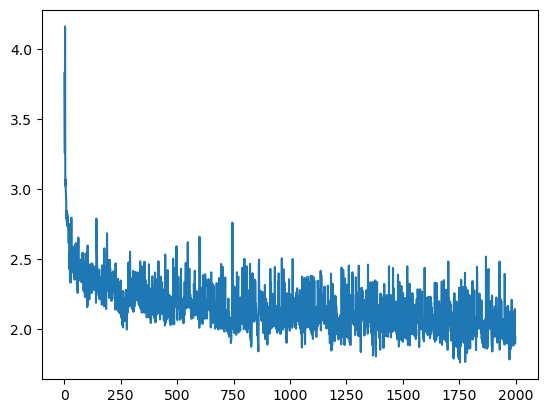

In [81]:
plt.plot(lossi)